<a href="https://colab.research.google.com/github/TamBui1706/DeepLearningCourse/blob/main/Week04/Week04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Import thư viện

In [ ]:
!pip install underthesea
import os
import json
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from typing import Dict, List, Tuple, Any
import time
import copy
import random
import requests
from bs4 import BeautifulSoup
from torch.utils.data import Dataset, DataLoader
from underthesea import word_tokenize
import re
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from torch.optim.lr_scheduler import CosineAnnealingLR

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.9 MB/s eta 0:00:00


#2. Định nghĩa cấu hình

In [ ]:
# Cấu hình dữ liệu
DATA_DIR = "crawled_data"
PROCESSED_DATA_DIR = "processed_data"
MODEL_SAVE_DIR = "saved_models"

# Tạo thư mục nếu chưa tồn tại
for directory in [DATA_DIR, PROCESSED_DATA_DIR, MODEL_SAVE_DIR]:
    os.makedirs(directory, exist_ok=True)

# Cấu hình dữ liệu
MAX_SEQ_LEN = 256
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.1

# Cấu hình mô hình
EMBEDDING_DIM = 300
HIDDEN_DIM = 128
NUM_LAYERS = 2
DROPOUT = 0.3
BIDIRECTIONAL = True
ATTENTION_DIM = 64

# Cấu hình huấn luyện
LEARNING_RATE = 0.001
EPOCHS = 10
EARLY_STOPPING_PATIENCE = 5

# Cấu hình thiết bị
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Danh sách các thể loại muốn crawl
CATEGORIES = [
    "thoi-su",
    "the-gioi",
    "bat-dong-san",
    "giao-duc"
]

# Ánh xạ nhãn
LABEL_MAP = {cat: idx for idx, cat in enumerate(sorted(CATEGORIES))}
INV_LABEL_MAP = {idx: cat for cat, idx in LABEL_MAP.items()}

#3. Thu thập dữ liệu(Crawler)

In [ ]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def get_text_from_tag(tag):
    if tag is None:
        return ""
    return tag.get_text().strip()

def get_article_urls(category, num_pages=5):
    """Lấy URL các bài báo từ một chuyên mục"""
    urls = []
    base_url = f"https://vnexpress.net/{category}"

    for page in range(1, num_pages + 1):
        try:
            if page == 1:
                url = base_url
            else:
                url = f"{base_url}-p{page}"

            print(f"Đang crawl trang {page} của chuyên mục {category}...")
            response = requests.get(url)
            soup = BeautifulSoup(response.content, 'html.parser')

            # Tìm tất cả các bài viết
            articles = soup.find_all('article', class_='item-news')

            for article in articles:
                # Tìm link của bài viết
                title_tag = article.find('h3', class_='title-news')
                if title_tag and title_tag.a:
                    article_url = title_tag.a['href']
                    urls.append(article_url)

            time.sleep(1)  # Tránh request quá nhanh

        except Exception as e:
            print(f"Lỗi khi crawl trang {page} của chuyên mục {category}: {e}")

    return urls

def extract_article_content(url):
    """Trích xuất nội dung từ một bài báo"""
    try:
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')

        # Lấy tiêu đề
        title = ""
        title_tag = soup.find('h1', class_='title-detail')
        if title_tag:
            title = get_text_from_tag(title_tag)

        # Lấy mô tả
        description = ""
        desc_tag = soup.find('p', class_='description')
        if desc_tag:
            description = get_text_from_tag(desc_tag)

        # Lấy nội dung
        content = ""
        article_content = soup.find('article', class_='fck_detail')
        if article_content:
            paragraphs = article_content.find_all('p', class_='Normal')
            for p in paragraphs:
                content += get_text_from_tag(p) + " "

        # Kết hợp tất cả thông tin
        full_content = f"{title}\n\n{description}\n\n{content}".strip()
        return full_content

    except Exception as e:
        print(f"Lỗi khi trích xuất nội dung từ {url}: {e}")
        return ""

def crawl_category(category, num_pages=5, output_dir=DATA_DIR):
    """Crawl tất cả bài báo từ một chuyên mục và lưu vào file"""
    category_dir = os.path.join(output_dir, category)
    create_dir(category_dir)

    # Lấy danh sách URL
    article_urls = get_article_urls(category, num_pages)
    print(f"Đã tìm thấy {len(article_urls)} bài báo trong chuyên mục {category}")

    # Crawl từng bài
    for i, url in enumerate(article_urls):
        try:
            article_id = f"{i+1:04d}"
            content = extract_article_content(url)

            if content:
                file_path = os.path.join(category_dir, f"{article_id}.txt")

                with open(file_path, 'w', encoding='utf-8') as f:
                    f.write(content)

                print(f"Đã lưu bài {article_id} trong chuyên mục {category}")

            time.sleep(0.5)  # Tránh request quá nhanh

        except Exception as e:
            print(f"Lỗi khi xử lý URL {url}: {e}")

    print(f"Hoàn thành crawl chuyên mục {category}")

In [ ]:
def crawl_all_categories(categories=CATEGORIES, pages_per_category=5):
    """Crawl tất cả các chuyên mục"""
    start_time = time.time()

    for category in categories:
        print(f"\nBắt đầu crawl chuyên mục {category}...")
        crawl_category(category, num_pages=pages_per_category)

    elapsed_time = time.time() - start_time
    print(f"\nĐã hoàn thành crawl tất cả chuyên mục trong {elapsed_time:.2f} giây")

    # Tạo mapping data
    create_mapping_file()

def create_mapping_file():
    """Tạo file mapping giữa đường dẫn file và nhãn"""
    mapping_data = []

    for category in CATEGORIES:
        category_dir = os.path.join(DATA_DIR, category)
        if os.path.exists(category_dir):
            for file_name in os.listdir(category_dir):
                if file_name.endswith('.txt'):
                    file_path = os.path.join(category_dir, file_name)
                    mapping_data.append({
                        'file_path': file_path,
                        'label': category
                    })

    mapping_file = os.path.join(DATA_DIR, "mapping_data.json")
    with open(mapping_file, 'w', encoding='utf-8') as f:
        json.dump(mapping_data, f, ensure_ascii=False, indent=4)

    print(f"Đã tạo file mapping với {len(mapping_data)} bài báo")

# Crawl dữ liệu (Uncomment để chạy crawl hoặc sử dụng dữ liệu đã crawl)
crawl_all_categories(pages_per_category=10)  # Crawl 3 trang cho mỗi chuyên mục


Bắt đầu crawl chuyên mục thoi-su...
Đang crawl trang 1 của chuyên mục thoi-su...
Đang crawl trang 2 của chuyên mục thoi-su...
Đang crawl trang 3 của chuyên mục thoi-su...
Đang crawl trang 4 của chuyên mục thoi-su...
Đang crawl trang 5 của chuyên mục thoi-su...
Đang crawl trang 6 của chuyên mục thoi-su...
Đang crawl trang 7 của chuyên mục thoi-su...
Đang crawl trang 8 của chuyên mục thoi-su...
Đang crawl trang 9 của chuyên mục thoi-su...
Đang crawl trang 10 của chuyên mục thoi-su...
Đã tìm thấy 315 bài báo trong chuyên mục thoi-su
Đã lưu bài 0001 trong chuyên mục thoi-su
Đã lưu bài 0002 trong chuyên mục thoi-su
Đã lưu bài 0004 trong chuyên mục thoi-su
Đã lưu bài 0005 trong chuyên mục thoi-su
Đã lưu bài 0007 trong chuyên mục thoi-su
Đã lưu bài 0008 trong chuyên mục thoi-su
Đã lưu bài 0009 trong chuyên mục thoi-su
Đã lưu bài 0010 trong chuyên mục thoi-su
Đã lưu bài 0011 trong chuyên mục thoi-su
Đã lưu bài 0012 trong chuyên mục thoi-su
Đã lưu bài 0013 trong chuyên mục thoi-su
Đã lưu bài 0

#4. Tiền xử lý dữ liệu

In [ ]:
class Vocabulary:
    def __init__(self, min_freq: int = 2):
        self.token2idx: Dict[str, int] = {}
        self.idx2token: Dict[int, str] = {}
        self.token_counts: Dict[str, int] = {}
        self.min_freq = min_freq

        self.pad_token, self.unk_token = "<PAD>", "<UNK>"
        self.pad_idx, self.unk_idx = 0, 1
        self.token2idx[self.pad_token] = self.pad_idx
        self.token2idx[self.unk_token] = self.unk_idx
        self.idx2token[self.pad_idx] = self.pad_token
        self.idx2token[self.unk_idx] = self.unk_token
        self.vocab_size = 2

    def build_vocab(self, texts: List[str]) -> None:
        """Xây dựng từ điển từ danh sách văn bản đã được tokenize."""
        for text in texts:
            for token in text.split():
                if token in self.token_counts:
                    self.token_counts[token] += 1
                else:
                    self.token_counts[token] = 1

        # Thêm các token xuất hiện đủ số lần vào từ điển
        for token, count in self.token_counts.items():
            if count >= self.min_freq and token not in self.token2idx:
                self.token2idx[token] = self.vocab_size
                self.idx2token[self.vocab_size] = token
                self.vocab_size += 1

    def text_to_indices(self, text: str, max_len: int) -> torch.Tensor:
        """Chuyển văn bản thành chuỗi chỉ số với padding/truncating."""
        tokens = text.split()
        indices = []

        for i in range(min(len(tokens), max_len)):
            token = tokens[i]
            indices.append(self.token2idx.get(token, self.unk_idx))

        # Padding
        while len(indices) < max_len:
            indices.append(self.pad_idx)

        return torch.tensor(indices, dtype=torch.long)

    def save_vocab(self, path: str) -> None:
        """Lưu từ điển xuống file."""
        with open(path, 'w', encoding='utf-8') as f:
            for token, idx in self.token2idx.items():
                f.write(f"{token}\t{idx}\n")

    def load_vocab(self, path: str) -> None:
        """Tải từ điển từ file."""
        self.token2idx = {}
        self.idx2token = {}
        self.vocab_size = 0

        with open(path, 'r', encoding='utf-8') as f:
            for line in f:
                token, idx = line.strip().split('\t')
                idx = int(idx)
                self.token2idx[token] = idx
                self.idx2token[idx] = token
                self.vocab_size = max(self.vocab_size, idx + 1)

        # Đảm bảo có các token đặc biệt
        self.pad_idx = self.token2idx.get(self.pad_token, 0)
        self.unk_idx = self.token2idx.get(self.unk_token, 1)

In [ ]:
def normalize_unicode(text: str) -> str:
    """Chuẩn hóa Unicode cho văn bản tiếng Việt."""
    import unicodedata
    text = unicodedata.normalize('NFC', text)
    return text

def clean_text(text: str) -> str:
    """Làm sạch văn bản."""
    # Loại bỏ HTML
    text = re.sub(r'<[^>]+>', '', text)

    # Loại bỏ URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Loại bỏ các ký tự đặc biệt và dấu câu thừa
    text = re.sub(r'[^\w\s.,!?]', ' ', text)

    # Thay thế nhiều dấu cách bằng một dấu cách
    text = re.sub(r'\s+', ' ', text)

    # Loại bỏ khoảng trắng thừa
    text = text.strip()

    return text

def preprocess_text(text: str) -> str:
    """Tiền xử lý văn bản tiếng Việt."""
    # Chuẩn hóa Unicode
    text = normalize_unicode(text)

    # Làm sạch văn bản
    text = clean_text(text)

    # Tách từ tiếng Việt
    text = word_tokenize(text, format="text")

    return text.lower()

In [ ]:
def load_data(mapping_file: str) -> List[Dict[str, Any]]:
    """Tải dữ liệu từ file mapping."""
    with open(mapping_file, 'r', encoding='utf-8') as f:
        mapping_data = json.load(f)

    dataset = []
    for item in mapping_data:
        file_path = item['file_path']
        label = item['label']

        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read()

            # Tiền xử lý nội dung
            processed_content = preprocess_text(content)

            dataset.append({
                'text': processed_content,
                'label': LABEL_MAP[label]  # Chuyển nhãn sang số
            })

        except Exception as e:
            print(f"Lỗi khi xử lý file {file_path}: {e}")

    return dataset

def split_data(data, val_ratio=0.2, test_ratio=0.1):
    """Chia dữ liệu thành train/val/test."""
    # Đầu tiên tách test
    train_val, test = train_test_split(
        data, test_size=test_ratio, random_state=42, stratify=[d['label'] for d in data]
    )

    # Sau đó tách validation từ phần train
    train, val = train_test_split(
        train_val,
        test_size=val_ratio/(1-test_ratio),  # Điều chỉnh tỷ lệ
        random_state=42,
        stratify=[d['label'] for d in train_val]
    )

    return train, val, test

def build_vocabulary(data, min_freq=2):
    """Xây dựng từ điển từ dữ liệu train."""
    texts = [item['text'] for item in data]
    vocab = Vocabulary(min_freq=min_freq)
    vocab.build_vocab(texts)
    print(f"Kích thước từ điển: {vocab.vocab_size} từ")
    return vocab

In [ ]:
class NewsDataset(Dataset):
    def __init__(self, data, vocab, max_len):
        self.data = data
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        text = item['text']
        label = item['label']

        # Chuyển văn bản thành tensor
        text_tensor = self.vocab.text_to_indices(text, self.max_len)
        label_tensor = torch.tensor(label, dtype=torch.long)

        return text_tensor, label_tensor

def create_data_loaders(train_data, val_data, test_data, vocab, max_len, batch_size):
    """Tạo DataLoader cho các tập dữ liệu."""
    train_dataset = NewsDataset(train_data, vocab, max_len)
    val_dataset = NewsDataset(val_data, vocab, max_len)
    test_dataset = NewsDataset(test_data, vocab, max_len)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader

def preprocess_all_data():
    """Tiền xử lý toàn bộ dữ liệu và lưu xuống file."""
    print("Bắt đầu tiền xử lý dữ liệu...")

    # Tạo thư mục lưu trữ nếu chưa tồn tại
    os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)

    # Tải dữ liệu từ mapping file
    mapping_file = os.path.join(DATA_DIR, "mapping_data.json")
    if not os.path.exists(mapping_file):
        print(f"Không tìm thấy file {mapping_file}. Vui lòng crawl dữ liệu trước.")
        return

    data = load_data(mapping_file)
    print(f"Đã tải {len(data)} mẫu dữ liệu")

    # Chia dữ liệu
    train_data, val_data, test_data = split_data(
        data, val_ratio=VALIDATION_SPLIT, test_ratio=TEST_SPLIT
    )

    print(f"Số lượng mẫu: Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")

    # Xây dựng từ điển
    vocab = build_vocabulary(train_data, min_freq=2)

    # Lưu dữ liệu đã xử lý
    with open(os.path.join(PROCESSED_DATA_DIR, 'train_data.pkl'), 'wb') as f:
        pickle.dump(train_data, f)

    with open(os.path.join(PROCESSED_DATA_DIR, 'val_data.pkl'), 'wb') as f:
        pickle.dump(val_data, f)

    with open(os.path.join(PROCESSED_DATA_DIR, 'test_data.pkl'), 'wb') as f:
        pickle.dump(test_data, f)

    with open(os.path.join(PROCESSED_DATA_DIR, 'vocab.pkl'), 'wb') as f:
        pickle.dump(vocab, f)

    # Lưu thông tin dataset
    dataset_info = {
        'train_size': len(train_data),
        'val_size': len(val_data),
        'test_size': len(test_data),
        'vocab_size': vocab.vocab_size,
        'num_classes': len(LABEL_MAP),
        'class_distribution': {
            'train': {str(label): sum(1 for item in train_data if item['label'] == label) for label in range(len(LABEL_MAP))},
            'val': {str(label): sum(1 for item in val_data if item['label'] == label) for label in range(len(LABEL_MAP))},
            'test': {str(label): sum(1 for item in test_data if item['label'] == label) for label in range(len(LABEL_MAP))}
        },
        'label_mapping': LABEL_MAP
    }

    with open(os.path.join(PROCESSED_DATA_DIR, 'dataset_info.json'), 'w', encoding='utf-8') as f:
        json.dump(dataset_info, f, ensure_ascii=False, indent=4)

    print(f"Đã hoàn thành tiền xử lý và lưu dữ liệu tại {PROCESSED_DATA_DIR}")

    return vocab, train_data, val_data, test_data

def load_processed_data():
    """Tải dữ liệu đã được tiền xử lý."""
    try:
        with open(os.path.join(PROCESSED_DATA_DIR, 'vocab.pkl'), 'rb') as f:
            vocab = pickle.load(f)

        with open(os.path.join(PROCESSED_DATA_DIR, 'train_data.pkl'), 'rb') as f:
            train_data = pickle.load(f)

        with open(os.path.join(PROCESSED_DATA_DIR, 'val_data.pkl'), 'rb') as f:
            val_data = pickle.load(f)

        with open(os.path.join(PROCESSED_DATA_DIR, 'test_data.pkl'), 'rb') as f:
            test_data = pickle.load(f)

        with open(os.path.join(PROCESSED_DATA_DIR, 'dataset_info.json'), 'r', encoding='utf-8') as f:
            dataset_info = json.load(f)

        print("Đã tải dữ liệu đã tiền xử lý")
        print(f"Số lượng mẫu: Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")
        print(f"Kích thước từ điển: {vocab.vocab_size} từ")

        return vocab, train_data, val_data, test_data, dataset_info

    except FileNotFoundError:
        print("Không tìm thấy dữ liệu đã tiền xử lý. Vui lòng chạy preprocess_all_data() trước.")
        return None, None, None, None, None

# Tiền xử lý dữ liệu (Uncomment để chạy)
vocab, train_data, val_data, test_data = preprocess_all_data()

Bắt đầu tiền xử lý dữ liệu...
Đã tải 1240 mẫu dữ liệu
Số lượng mẫu: Train: 867, Val: 249, Test: 124
Kích thước từ điển: 11008 từ
Đã hoàn thành tiền xử lý và lưu dữ liệu tại processed_data


#5.Mô hình LSTM + Attention


In [ ]:
class LSTMAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, attention_dim,
                output_dim, num_layers, bidirectional=True, dropout=0.3, pad_idx=0):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)

        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )

        self.bidirectional = bidirectional
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Nếu sử dụng LSTM hai chiều, hidden_dim cần nhân đôi
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim

        # Lớp attention
        self.attention = nn.Linear(lstm_output_dim, attention_dim)
        self.attention_combine = nn.Linear(attention_dim, 1)

        # Fully connected layer để phân loại
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(lstm_output_dim, output_dim)
        )

    def forward(self, text):
        # text shape: [batch_size, seq_length]

        # Nhúng từ
        embedded = self.embedding(text)
        # embedded shape: [batch_size, seq_length, embedding_dim]

        # Qua LSTM
        # packed_output shape: [batch_size, seq_length, hidden_dim * (2 if bidirectional else 1)]
        packed_output, (hidden, cell) = self.lstm(embedded)

        # Tính attention weights
        attention_in = torch.tanh(self.attention(packed_output))
        attention_weights = torch.softmax(self.attention_combine(attention_in), dim=1)

        # Áp dụng attention
        context = torch.sum(attention_weights * packed_output, dim=1)

        # Đưa qua classifier
        output = self.classifier(context)

        return output, attention_weights

#6. Đánh giá và EarlyStopping


In [ ]:
class EarlyStopping:
    """Cơ chế dừng sớm để tránh overfitting."""
    def __init__(self, patience=5, verbose=True, delta=0, path='best_model.pt'):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

def evaluate_predictions(y_true, y_pred):
    """Tính các metrics đánh giá."""
    accuracy = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted
    }

def plot_confusion_matrix(y_true, y_pred, classes):
    """Vẽ ma trận nhầm lẫn."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)

    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

    return plt.gcf()

#7. Hàm huấn luyện và đánh giá

In [ ]:
def set_seed(seed):
    """Cài đặt seed cho tính tái tạo."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

def train_model(run_name, config, seed=42):
    """Huấn luyện mô hình với cấu hình cho trước."""
    set_seed(seed)

    # Tải dữ liệu đã tiền xử lý
    vocab, train_data, val_data, test_data, dataset_info = load_processed_data()

    if vocab is None:
        print("Lỗi khi tải dữ liệu đã tiền xử lý.")
        return None

    # Tạo dataloaders
    train_loader, val_loader, test_loader = create_data_loaders(
        train_data, val_data, test_data,
        vocab, MAX_SEQ_LEN, config['batch_size']
    )

    # Khởi tạo mô hình
    model = LSTMAttention(
        vocab_size=vocab.vocab_size,
        embedding_dim=config['embedding_dim'],
        hidden_dim=config['hidden_dim'],
        attention_dim=config['attention_dim'],
        output_dim=len(LABEL_MAP),
        num_layers=config['num_layers'],
        bidirectional=BIDIRECTIONAL,
        dropout=config['dropout'],
        pad_idx=vocab.pad_idx
    ).to(DEVICE)

    # Loss function và optimizer
    criterion = nn.CrossEntropyLoss()

    if config['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    elif config['optimizer'] == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=config['learning_rate'])
    elif config['optimizer'] == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters(), lr=config['learning_rate'])
    else:
        optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

    # Learning rate scheduler
    scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)

    # Early stopping
    model_save_dir = os.path.join(MODEL_SAVE_DIR, run_name)
    os.makedirs(model_save_dir, exist_ok=True)
    model_path = os.path.join(model_save_dir, 'best_model.pt')
    early_stopping = EarlyStopping(patience=EARLY_STOPPING_PATIENCE, verbose=True, path=model_path)

    # Khởi tạo wandb
    wandb.init(
        project="vietnamese-news-classification",
        name=run_name,
        config=config
    )

    # Theo dõi metrics
    train_losses = []
    val_losses = []
    train_metrics = []
    val_metrics = []

    # Bắt đầu huấn luyện
    print(f"Bắt đầu huấn luyện mô hình {run_name}...")
    start_time = time.time()

    for epoch in range(1, EPOCHS + 1):
        # Training
        model.train()
        epoch_loss = 0
        true_labels = []
        pred_labels = []

        for batch in train_loader:
            text, labels = batch
            text, labels = text.to(DEVICE), labels.to(DEVICE)

            # Forward pass
            optimizer.zero_grad()
            predictions, _ = model(text)

            # Tính loss
            loss = criterion(predictions, labels)

            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            # Cập nhật metrics
            epoch_loss += loss.item() * text.size(0)

            _, preds = torch.max(predictions, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

        epoch_loss /= len(train_loader.dataset)
        train_losses.append(epoch_loss)

        train_metric = evaluate_predictions(true_labels, pred_labels)
        train_metrics.append(train_metric)

        # Validation
        model.eval()
        val_loss = 0
        true_labels = []
        pred_labels = []

        with torch.no_grad():
            for batch in val_loader:
                text, labels = batch
                text, labels = text.to(DEVICE), labels.to(DEVICE)

                predictions, _ = model(text)
                loss = criterion(predictions, labels)

                val_loss += loss.item() * text.size(0)

                _, preds = torch.max(predictions, 1)
                true_labels.extend(labels.cpu().numpy())
                pred_labels.extend(preds.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        val_metric = evaluate_predictions(true_labels, pred_labels)
        val_metrics.append(val_metric)

        # Update scheduler
        scheduler.step()

        # Log to wandb
        wandb.log({
            'epoch': epoch,
            'train_loss': epoch_loss,
            'val_loss': val_loss,
            'train_accuracy': train_metric['accuracy'],
            'val_accuracy': val_metric['accuracy'],
            'train_f1_macro': train_metric['f1_macro'],
            'val_f1_macro': val_metric['f1_macro'],
            'learning_rate': scheduler.get_last_lr()[0]
        })

        # Print progress
        print(f'Epoch: {epoch}/{EPOCHS}')
        print(f'Train Loss: {epoch_loss:.4f}, Accuracy: {train_metric["accuracy"]:.4f}, F1: {train_metric["f1_macro"]:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Accuracy: {val_metric["accuracy"]:.4f}, F1: {val_metric["f1_macro"]:.4f}')

        # Early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break

    training_time = time.time() - start_time
    print(f'Hoàn thành huấn luyện trong {training_time/60:.2f} phút')

    # Lưu history
    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_accuracy': [m['accuracy'] for m in train_metrics],
        'val_accuracy': [m['accuracy'] for m in val_metrics],
        'train_f1': [m['f1_macro'] for m in train_metrics],
        'val_f1': [m['f1_macro'] for m in val_metrics],
    }

    with open(os.path.join(model_save_dir, 'training_history.json'), 'w') as f:
        json.dump(history, f)

    # Vẽ biểu đồ huấn luyện
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot([m['accuracy'] for m in train_metrics], label='Train Accuracy')
    plt.plot([m['accuracy'] for m in val_metrics], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(model_save_dir, 'training_curves.png'))

    # Evaluate on test set
    print("Đánh giá mô hình trên tập test...")

    # Load best model
    model.load_state_dict(torch.load(model_path))
    model.eval()

    test_loss = 0
    test_true_labels = []
    test_pred_labels = []

    with torch.no_grad():
        for batch in test_loader:
            text, labels = batch
            text, labels = text.to(DEVICE), labels.to(DEVICE)

            predictions, _ = model(text)
            loss = criterion(predictions, labels)

            test_loss += loss.item() * text.size(0)

            _, preds = torch.max(predictions, 1)
            test_true_labels.extend(labels.cpu().numpy())
            test_pred_labels.extend(preds.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    test_metrics = evaluate_predictions(test_true_labels, test_pred_labels)

    # Log test metrics
    wandb.log({
        'test_loss': test_loss,
        'test_accuracy': test_metrics['accuracy'],
        'test_f1_macro': test_metrics['f1_macro'],
        'test_f1_weighted': test_metrics['f1_weighted']
    })

    # Print test results
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_metrics["accuracy"]:.4f}')
    print(f'Test F1 (Macro): {test_metrics["f1_macro"]:.4f}')
    print(f'Test F1 (Weighted): {test_metrics["f1_weighted"]:.4f}')

    # Save classification report
    class_names = [INV_LABEL_MAP[i] for i in range(len(LABEL_MAP))]
    report = classification_report(
        test_true_labels, test_pred_labels,
        target_names=class_names,
        output_dict=True
    )

    with open(os.path.join(model_save_dir, 'test_results.json'), 'w') as f:
        json.dump({
            'test_loss': test_loss,
            'test_metrics': test_metrics,
            'classification_report': report
        }, f)

    # Plot confusion matrix
    cm_fig = plot_confusion_matrix(test_true_labels, test_pred_labels, class_names)
    cm_fig.savefig(os.path.join(model_save_dir, 'confusion_matrix.png'))

    # Log confusion matrix to wandb
    wandb.log({'confusion_matrix': wandb.Image(cm_fig)})

    # Kết thúc wandb run
    wandb.finish()

    return {
        'config': config,
        'test_loss': test_loss,
        'test_accuracy': test_metrics['accuracy'],
        'test_f1_macro': test_metrics['f1_macro'],
        'test_f1_weighted': test_metrics['f1_weighted'],
        'history': history
    }

#8. Cấu hình thí nghiệm và chạy huấn luyện

In [ ]:
# Định nghĩa các cấu hình siêu tham số
CONFIGURATIONS = [
    {
        "name": "config_1",
        "description": "Baseline",
        "params": {
            "hidden_dim": 128,
            "attention_dim": 64,
            "embedding_dim": 300,
            "num_layers": 2,
            "batch_size": 32,
            "dropout": 0.5,
            "learning_rate": 0.001,
            "optimizer": "adam",
        },
    },
    {
        "name": "config_2",
        "description": "Larger model",
        "params": {
            "hidden_dim": 256,
            "attention_dim": 128,
            "embedding_dim": 400,
            "num_layers": 3,
            "batch_size": 32,
            "dropout": 0.4,
            "learning_rate": 0.001,
            "optimizer": "adamw",
        },
    },
    {
        "name": "config_3",
        "description": "Different learning rate and optimizer",
        "params": {
            "hidden_dim": 128,
            "attention_dim": 64,
            "embedding_dim": 300,
            "num_layers": 2,
            "batch_size": 16,
            "dropout": 0.3,
            "learning_rate": 0.003,
            "optimizer": "rmsprop",
        },
    },
]

def run_experiments(configs=CONFIGURATIONS, runs_per_config=3):
    """Chạy thí nghiệm với nhiều cấu hình và nhiều lần chạy."""
    # Thư mục để lưu kết quả
    results_dir = "results"
    os.makedirs(results_dir, exist_ok=True)

    all_results = []
    summary_results = []

    for config_item in configs:
        config_name = config_item["name"]
        config_params = config_item["params"]

        print(f"\n{'=' * 50}")
        print(f"Chạy thí nghiệm với cấu hình: {config_name}")
        print(f"Mô tả: {config_item['description']}")
        print(f"Tham số: {config_params}")
        print(f"{'=' * 50}")

        config_results = []

        # Chạy nhiều lần với các seed khác nhau
        for run_id in range(1, runs_per_config + 1):
            seed = 42 + run_id - 1  # Seed khác nhau cho mỗi lần chạy
            run_name = f"{config_name}_run{run_id}"

            print(f"\nBắt đầu chạy {run_name} với seed {seed}...")

            # Huấn luyện mô hình
            results = train_model(run_name, config_params, seed=seed)

            if results:
                config_results.append(results)
                all_results.append(results)

        # Tính trung bình và độ lệch chuẩn
        test_losses = [r["test_loss"] for r in config_results]
        test_accuracies = [r["test_accuracy"] for r in config_results]
        test_f1s = [r["test_f1_macro"] for r in config_results]
        test_errors = [1 - acc for acc in test_accuracies]

        avg_test_loss = np.mean(test_losses)
        std_test_loss = np.std(test_losses)
        avg_test_accuracy = np.mean(test_accuracies)
        std_test_accuracy = np.std(test_accuracies)
        avg_test_f1 = np.mean(test_f1s)
        std_test_f1 = np.std(test_f1s)
        avg_test_error = np.mean(test_errors)
        std_test_error = np.std(test_errors)

        # Lưu tổng kết
        summary = {
            "config_name": config_name,
            "description": config_item["description"],
            "avg_test_loss": avg_test_loss,
            "std_test_loss": std_test_loss,
            "avg_test_accuracy": avg_test_accuracy,
            "std_test_accuracy": std_test_accuracy,
            "avg_test_f1": avg_test_f1,
            "std_test_f1": std_test_f1,
            "avg_test_error": avg_test_error,
            "std_test_error": std_test_error,
            "params": config_params,
        }
        summary_results.append(summary)

        print(f"\n{'=' * 50}")
        print(f"Kết quả tổng hợp cho cấu hình {config_name}:")
        print(f"Mô tả: {config_item['description']}")
        print(f"Test Loss: {avg_test_loss:.4f} ± {std_test_loss:.4f}")
        print(f"Test Accuracy: {avg_test_accuracy:.4f} ± {std_test_accuracy:.4f}")
        print(f"Test Error: {avg_test_error:.4f} ± {std_test_error:.4f}")
        print(f"Test F1: {avg_test_f1:.4f} ± {std_test_f1:.4f}")
        print(f"{'=' * 50}\n")

    # Lưu kết quả chi tiết
    detailed_results_path = os.path.join(results_dir, "detailed_results.json")
    with open(detailed_results_path, "w") as f:
        json.dump(all_results, f, indent=4)

    # Lưu tổng kết
    summary_results_path = os.path.join(results_dir, "summary_results.json")
    with open(summary_results_path, "w") as f:
        json.dump(summary_results, f, indent=4)

    # Tạo DataFrame và lưu CSV
    summary_df = pd.DataFrame(summary_results)
    summary_df = summary_df[[
        "config_name", "description", "avg_test_loss", "std_test_loss",
        "avg_test_accuracy", "std_test_accuracy", "avg_test_error",
        "std_test_error", "avg_test_f1", "std_test_f1"
    ]]

    summary_csv_path = os.path.join(results_dir, "summary_results.csv")
    summary_df.to_csv(summary_csv_path, index=False)

    # Vẽ biểu đồ so sánh
    plt.figure(figsize=(12, 6))

    # Accuracy comparison
    plt.subplot(1, 2, 1)
    bars = plt.bar(
        summary_df["config_name"],
        summary_df["avg_test_accuracy"],
        yerr=summary_df["std_test_accuracy"],
        capsize=5
    )
    plt.xlabel("Configuration")
    plt.ylabel("Test Accuracy")
    plt.title("Accuracy Comparison")
    plt.ylim(0.7, 1.0)  # Adjust as needed

    # F1 comparison
    plt.subplot(1, 2, 2)
    plt.bar(
        summary_df["config_name"],
        summary_df["avg_test_f1"],
        yerr=summary_df["std_test_f1"],
        capsize=5
    )
    plt.xlabel("Configuration")
    plt.ylabel("Test F1 Score (Macro)")
    plt.title("F1 Score Comparison")
    plt.ylim(0.7, 1.0)  # Adjust as needed

    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "metric_comparisons.png"), dpi=300)

    # Tìm config tốt nhất
    best_config_idx = summary_df["avg_test_accuracy"].idxmax()
    best_config = summary_df.iloc[best_config_idx]

    print(f"\nCấu hình tốt nhất (dựa trên Accuracy cao nhất): {best_config['config_name']}")
    print(f"Mô tả: {best_config['description']}")
    print(f"Test Accuracy: {best_config['avg_test_accuracy']:.4f} ± {best_config['std_test_accuracy']:.4f}")
    print(f"Test Error: {best_config['avg_test_error']:.4f} ± {best_config['std_test_error']:.4f}")
    print(f"Test F1: {best_config['avg_test_f1']:.4f} ± {best_config['std_test_f1']:.4f}")

    return summary_df

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#9. Hàm main

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: builehongtamk16 (builehongtamk16-hi) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Đã đăng nhập vào Wandb

Bắt đầu thí nghiệm với các cấu hình khác nhau...

Chạy thí nghiệm với cấu hình: config_1
Mô tả: Baseline
Tham số: {'hidden_dim': 128, 'attention_dim': 64, 'embedding_dim': 300, 'num_layers': 2, 'batch_size': 32, 'dropout': 0.5, 'learning_rate': 0.001, 'optimizer': 'adam'}

Bắt đầu chạy config_1_run1 với seed 42...
Đã tải dữ liệu đã tiền xử lý
Số lượng mẫu: Train: 867, Val: 249, Test: 124
Kích thước từ điển: 11008 từ


Bắt đầu huấn luyện mô hình config_1_run1...
Epoch: 1/10
Train Loss: 1.2268, Accuracy: 0.5087, F1: 0.4763
Val Loss: 0.6810, Accuracy: 0.6627, F1: 0.6351
Validation loss decreased (inf --> 0.680989). Saving model...
Epoch: 2/10
Train Loss: 0.4494, Accuracy: 0.8339, F1: 0.8345
Val Loss: 0.4098, Accuracy: 0.8594, F1: 0.8567
Validation loss decreased (0.680989 --> 0.409780). Saving model...
Epoch: 3/10
Train Loss: 0.2098, Accuracy: 0.9308, F1: 0.9307
Val Loss: 0.4173, Accuracy: 0.8755, F1: 0.8751
EarlyStopping counter: 1 out of 5
Epoch: 4/10
Train Loss: 0.1276, Accuracy: 0.9608, F1: 0.9607
Val Loss: 0.5672, Accuracy: 0.8434, F1: 0.8299
EarlyStopping counter: 2 out of 5
Epoch: 5/10
Train Loss: 0.1046, Accuracy: 0.9792, F1: 0.9792
Val Loss: 0.3270, Accuracy: 0.8956, F1: 0.8958
Validation loss decreased (0.409780 --> 0.327012). Saving model...
Epoch: 6/10
Train Loss: 0.0553, Accuracy: 0.9815, F1: 0.9815
Val Loss: 0.3259, Accuracy: 0.8996, F1: 0.8982
Validation loss decreased (0.327012 --> 0.32

epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,█▇▇▆▅▃▂▂▁▁
test_accuracy,▁
test_f1_macro,▁
test_f1_weighted,▁
test_loss,▁
train_accuracy,▁▆▇███████
train_f1_macro,▁▆▇███████
train_loss,█▄▂▂▂▁▁▁▁▁
val_accuracy,▁▇▇▆██████
val_f1_macro,▁▇▇▆██████



Bắt đầu chạy config_1_run2 với seed 43...
Đã tải dữ liệu đã tiền xử lý
Số lượng mẫu: Train: 867, Val: 249, Test: 124
Kích thước từ điển: 11008 từ


Bắt đầu huấn luyện mô hình config_1_run2...
Epoch: 1/10
Train Loss: 1.2242, Accuracy: 0.5536, F1: 0.5405
Val Loss: 0.7753, Accuracy: 0.7430, F1: 0.7388
Validation loss decreased (inf --> 0.775288). Saving model...
Epoch: 2/10
Train Loss: 0.3851, Accuracy: 0.8766, F1: 0.8758
Val Loss: 0.8073, Accuracy: 0.7992, F1: 0.7724
EarlyStopping counter: 1 out of 5
Epoch: 3/10
Train Loss: 0.2164, Accuracy: 0.9273, F1: 0.9272
Val Loss: 0.3738, Accuracy: 0.8715, F1: 0.8715
Validation loss decreased (0.775288 --> 0.373810). Saving model...
Epoch: 4/10
Train Loss: 0.0916, Accuracy: 0.9723, F1: 0.9723
Val Loss: 0.5135, Accuracy: 0.8514, F1: 0.8469
EarlyStopping counter: 1 out of 5
Epoch: 5/10
Train Loss: 0.0456, Accuracy: 0.9896, F1: 0.9895
Val Loss: 0.4839, Accuracy: 0.8835, F1: 0.8827
EarlyStopping counter: 2 out of 5
Epoch: 6/10
Train Loss: 0.0329, Accuracy: 0.9885, F1: 0.9884
Val Loss: 0.4583, Accuracy: 0.8795, F1: 0.8786
EarlyStopping counter: 3 out of 5
Epoch: 7/10
Train Loss: 0.0283, Accuracy: 0

epoch,▁▂▃▄▅▆▇█
learning_rate,█▇▇▅▄▃▂▁
test_accuracy,▁
test_f1_macro,▁
test_f1_weighted,▁
test_loss,▁
train_accuracy,▁▆▇█████
train_f1_macro,▁▆▇█████
train_loss,█▃▂▁▁▁▁▁
val_accuracy,▁▄▇▆▇▇██
val_f1_macro,▁▃▇▆█▇██



Bắt đầu chạy config_1_run3 với seed 44...
Đã tải dữ liệu đã tiền xử lý
Số lượng mẫu: Train: 867, Val: 249, Test: 124
Kích thước từ điển: 11008 từ


Bắt đầu huấn luyện mô hình config_1_run3...
Epoch: 1/10
Train Loss: 1.2502, Accuracy: 0.4994, F1: 0.4969
Val Loss: 0.6437, Accuracy: 0.8353, F1: 0.8318
Validation loss decreased (inf --> 0.643714). Saving model...
Epoch: 2/10
Train Loss: 0.3583, Accuracy: 0.8858, F1: 0.8856
Val Loss: 0.3557, Accuracy: 0.8715, F1: 0.8703
Validation loss decreased (0.643714 --> 0.355710). Saving model...
Epoch: 3/10
Train Loss: 0.1455, Accuracy: 0.9550, F1: 0.9550
Val Loss: 0.4034, Accuracy: 0.8715, F1: 0.8677
EarlyStopping counter: 1 out of 5
Epoch: 4/10
Train Loss: 0.0804, Accuracy: 0.9735, F1: 0.9734
Val Loss: 0.3911, Accuracy: 0.8876, F1: 0.8850
EarlyStopping counter: 2 out of 5
Epoch: 5/10
Train Loss: 0.0386, Accuracy: 0.9908, F1: 0.9908
Val Loss: 0.3497, Accuracy: 0.9076, F1: 0.9067
Validation loss decreased (0.355710 --> 0.349690). Saving model...
Epoch: 6/10
Train Loss: 0.0282, Accuracy: 0.9931, F1: 0.9931
Val Loss: 0.3898, Accuracy: 0.8996, F1: 0.8966
EarlyStopping counter: 1 out of 5
Epoch: 7/1

epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,█▇▇▆▅▃▂▂▁▁
test_accuracy,▁
test_f1_macro,▁
test_f1_weighted,▁
test_loss,▁
train_accuracy,▁▆▇███████
train_f1_macro,▁▆▇███████
train_loss,█▃▂▁▁▁▁▁▁▁
val_accuracy,▁▄▄▅▇▆█▆▆▆
val_f1_macro,▁▄▄▅▇▆█▆▆▆



Kết quả tổng hợp cho cấu hình config_1:
Mô tả: Baseline
Test Loss: 0.5675 ± 0.1233
Test Accuracy: 0.8414 ± 0.0249
Test Error: 0.1586 ± 0.0249
Test F1: 0.8418 ± 0.0254


Chạy thí nghiệm với cấu hình: config_2
Mô tả: Larger model
Tham số: {'hidden_dim': 256, 'attention_dim': 128, 'embedding_dim': 400, 'num_layers': 3, 'batch_size': 32, 'dropout': 0.4, 'learning_rate': 0.001, 'optimizer': 'adamw'}

Bắt đầu chạy config_2_run1 với seed 42...
Đã tải dữ liệu đã tiền xử lý
Số lượng mẫu: Train: 867, Val: 249, Test: 124
Kích thước từ điển: 11008 từ


Bắt đầu huấn luyện mô hình config_2_run1...
Epoch: 1/10
Train Loss: 0.9536, Accuracy: 0.5963, F1: 0.5993
Val Loss: 0.5903, Accuracy: 0.7912, F1: 0.7858
Validation loss decreased (inf --> 0.590270). Saving model...
Epoch: 2/10
Train Loss: 0.3119, Accuracy: 0.8950, F1: 0.8949
Val Loss: 0.3137, Accuracy: 0.8916, F1: 0.8899
Validation loss decreased (0.590270 --> 0.313716). Saving model...
Epoch: 3/10
Train Loss: 0.1446, Accuracy: 0.9516, F1: 0.9514
Val Loss: 0.3380, Accuracy: 0.8795, F1: 0.8784
EarlyStopping counter: 1 out of 5
Epoch: 4/10
Train Loss: 0.0477, Accuracy: 0.9850, F1: 0.9850
Val Loss: 0.4014, Accuracy: 0.8795, F1: 0.8771
EarlyStopping counter: 2 out of 5
Epoch: 5/10
Train Loss: 0.0374, Accuracy: 0.9850, F1: 0.9849
Val Loss: 0.5542, Accuracy: 0.8474, F1: 0.8402
EarlyStopping counter: 3 out of 5
Epoch: 6/10
Train Loss: 0.0207, Accuracy: 0.9931, F1: 0.9930
Val Loss: 0.4420, Accuracy: 0.8876, F1: 0.8869
EarlyStopping counter: 4 out of 5
Epoch: 7/10
Train Loss: 0.0182, Accuracy: 0

epoch,▁▂▃▅▆▇█
learning_rate,█▇▆▅▄▂▁
test_accuracy,▁
test_f1_macro,▁
test_f1_weighted,▁
test_loss,▁
train_accuracy,▁▆▇████
train_f1_macro,▁▆▇████
train_loss,█▃▂▁▁▁▁
val_accuracy,▁█▇▇▅█▇
val_f1_macro,▁█▇▇▅█▇



Bắt đầu chạy config_2_run2 với seed 43...
Đã tải dữ liệu đã tiền xử lý
Số lượng mẫu: Train: 867, Val: 249, Test: 124
Kích thước từ điển: 11008 từ


Bắt đầu huấn luyện mô hình config_2_run2...
Epoch: 1/10
Train Loss: 0.9806, Accuracy: 0.5640, F1: 0.5707
Val Loss: 0.6810, Accuracy: 0.7510, F1: 0.7433
Validation loss decreased (inf --> 0.680954). Saving model...
Epoch: 2/10
Train Loss: 0.3462, Accuracy: 0.8927, F1: 0.8925
Val Loss: 0.7062, Accuracy: 0.7791, F1: 0.7690
EarlyStopping counter: 1 out of 5
Epoch: 3/10
Train Loss: 0.2206, Accuracy: 0.9227, F1: 0.9218
Val Loss: 0.4348, Accuracy: 0.8795, F1: 0.8784
Validation loss decreased (0.680954 --> 0.434800). Saving model...
Epoch: 4/10
Train Loss: 0.1303, Accuracy: 0.9562, F1: 0.9562
Val Loss: 0.5630, Accuracy: 0.8353, F1: 0.8376
EarlyStopping counter: 1 out of 5
Epoch: 5/10
Train Loss: 0.0877, Accuracy: 0.9712, F1: 0.9710
Val Loss: 0.3562, Accuracy: 0.9076, F1: 0.9074
Validation loss decreased (0.434800 --> 0.356195). Saving model...
Epoch: 6/10
Train Loss: 0.0346, Accuracy: 0.9919, F1: 0.9919
Val Loss: 0.4461, Accuracy: 0.8956, F1: 0.8955
EarlyStopping counter: 1 out of 5
Epoch: 7/1

epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,█▇▇▆▅▃▂▂▁▁
test_accuracy,▁
test_f1_macro,▁
test_f1_weighted,▁
test_loss,▁
train_accuracy,▁▆▇▇██████
train_f1_macro,▁▆▇▇██████
train_loss,█▃▃▂▂▁▁▁▁▁
val_accuracy,▁▂▇▅█▇█▇██
val_f1_macro,▁▂▇▅█▇█▇██



Bắt đầu chạy config_2_run3 với seed 44...
Đã tải dữ liệu đã tiền xử lý
Số lượng mẫu: Train: 867, Val: 249, Test: 124
Kích thước từ điển: 11008 từ


Bắt đầu huấn luyện mô hình config_2_run3...
Epoch: 1/10
Train Loss: 0.9608, Accuracy: 0.5513, F1: 0.5512
Val Loss: 0.4777, Accuracy: 0.8434, F1: 0.8388
Validation loss decreased (inf --> 0.477712). Saving model...
Epoch: 2/10
Train Loss: 0.2917, Accuracy: 0.9054, F1: 0.9052
Val Loss: 0.4362, Accuracy: 0.8353, F1: 0.8293
Validation loss decreased (0.477712 --> 0.436199). Saving model...
Epoch: 3/10
Train Loss: 0.1271, Accuracy: 0.9562, F1: 0.9561
Val Loss: 0.4437, Accuracy: 0.8835, F1: 0.8817
EarlyStopping counter: 1 out of 5
Epoch: 4/10
Train Loss: 0.0704, Accuracy: 0.9746, F1: 0.9746
Val Loss: 0.5208, Accuracy: 0.8795, F1: 0.8794
EarlyStopping counter: 2 out of 5
Epoch: 5/10
Train Loss: 0.0323, Accuracy: 0.9896, F1: 0.9896
Val Loss: 0.4796, Accuracy: 0.8876, F1: 0.8871
EarlyStopping counter: 3 out of 5
Epoch: 6/10
Train Loss: 0.0254, Accuracy: 0.9942, F1: 0.9942
Val Loss: 0.5789, Accuracy: 0.8876, F1: 0.8865
EarlyStopping counter: 4 out of 5
Epoch: 7/10
Train Loss: 0.0209, Accuracy: 0

epoch,▁▂▃▅▆▇█
learning_rate,█▇▆▅▄▂▁
test_accuracy,▁
test_f1_macro,▁
test_f1_weighted,▁
test_loss,▁
train_accuracy,▁▇▇████
train_f1_macro,▁▇▇████
train_loss,█▃▂▁▁▁▁
val_accuracy,▂▁▇▇██▇
val_f1_macro,▂▁▇▇██▇



Kết quả tổng hợp cho cấu hình config_2:
Mô tả: Larger model
Test Loss: 0.5118 ± 0.1114
Test Accuracy: 0.8414 ± 0.0331
Test Error: 0.1586 ± 0.0331
Test F1: 0.8400 ± 0.0360


Chạy thí nghiệm với cấu hình: config_3
Mô tả: Different learning rate and optimizer
Tham số: {'hidden_dim': 128, 'attention_dim': 64, 'embedding_dim': 300, 'num_layers': 2, 'batch_size': 16, 'dropout': 0.3, 'learning_rate': 0.003, 'optimizer': 'rmsprop'}

Bắt đầu chạy config_3_run1 với seed 42...
Đã tải dữ liệu đã tiền xử lý
Số lượng mẫu: Train: 867, Val: 249, Test: 124
Kích thước từ điển: 11008 từ


Bắt đầu huấn luyện mô hình config_3_run1...
Epoch: 1/10
Train Loss: 0.8461, Accuracy: 0.6920, F1: 0.6904
Val Loss: 0.3727, Accuracy: 0.8675, F1: 0.8696
Validation loss decreased (inf --> 0.372750). Saving model...
Epoch: 2/10
Train Loss: 0.1346, Accuracy: 0.9596, F1: 0.9594
Val Loss: 0.2380, Accuracy: 0.9237, F1: 0.9240
Validation loss decreased (0.372750 --> 0.237985). Saving model...
Epoch: 3/10
Train Loss: 0.0261, Accuracy: 0.9919, F1: 0.9919
Val Loss: 0.5786, Accuracy: 0.8353, F1: 0.8295
EarlyStopping counter: 1 out of 5
Epoch: 4/10
Train Loss: 0.0246, Accuracy: 0.9931, F1: 0.9931
Val Loss: 0.2447, Accuracy: 0.9317, F1: 0.9305
EarlyStopping counter: 2 out of 5
Epoch: 5/10
Train Loss: 0.0214, Accuracy: 0.9919, F1: 0.9919
Val Loss: 0.2344, Accuracy: 0.9357, F1: 0.9346
Validation loss decreased (0.237985 --> 0.234389). Saving model...
Epoch: 6/10
Train Loss: 0.0114, Accuracy: 0.9954, F1: 0.9953
Val Loss: 0.2327, Accuracy: 0.9317, F1: 0.9306
Validation loss decreased (0.234389 --> 0.23

epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,█▇▇▆▅▃▂▂▁▁
test_accuracy,▁
test_f1_macro,▁
test_f1_weighted,▁
test_loss,▁
train_accuracy,▁▇████████
train_f1_macro,▁▇████████
train_loss,█▂▁▁▁▁▁▁▁▁
val_accuracy,▃▇▁███▇▇██
val_f1_macro,▄▇▁███▇▇██



Bắt đầu chạy config_3_run2 với seed 43...
Đã tải dữ liệu đã tiền xử lý
Số lượng mẫu: Train: 867, Val: 249, Test: 124
Kích thước từ điển: 11008 từ


Bắt đầu huấn luyện mô hình config_3_run2...
Epoch: 1/10
Train Loss: 0.8506, Accuracy: 0.6770, F1: 0.6768
Val Loss: 0.5233, Accuracy: 0.8273, F1: 0.8138
Validation loss decreased (inf --> 0.523257). Saving model...
Epoch: 2/10
Train Loss: 0.1196, Accuracy: 0.9585, F1: 0.9584
Val Loss: 0.3078, Accuracy: 0.9076, F1: 0.9061
Validation loss decreased (0.523257 --> 0.307794). Saving model...
Epoch: 3/10
Train Loss: 0.0323, Accuracy: 0.9908, F1: 0.9907
Val Loss: 0.3391, Accuracy: 0.8996, F1: 0.8987
EarlyStopping counter: 1 out of 5
Epoch: 4/10
Train Loss: 0.0178, Accuracy: 0.9931, F1: 0.9930
Val Loss: 0.2854, Accuracy: 0.9036, F1: 0.9020
Validation loss decreased (0.307794 --> 0.285441). Saving model...
Epoch: 5/10
Train Loss: 0.0123, Accuracy: 0.9965, F1: 0.9965
Val Loss: 0.3071, Accuracy: 0.9116, F1: 0.9102
EarlyStopping counter: 1 out of 5
Epoch: 6/10
Train Loss: 0.0087, Accuracy: 0.9954, F1: 0.9953
Val Loss: 0.3393, Accuracy: 0.9116, F1: 0.9102
EarlyStopping counter: 2 out of 5
Epoch: 7/1

epoch,▁▂▃▄▅▅▆▇█
learning_rate,█▇▇▆▅▃▂▂▁
test_accuracy,▁
test_f1_macro,▁
test_f1_weighted,▁
test_loss,▁
train_accuracy,▁▇███████
train_f1_macro,▁▇███████
train_loss,█▂▁▁▁▁▁▁▁
val_accuracy,▁█▇▇█████
val_f1_macro,▁█▇▇█████



Bắt đầu chạy config_3_run3 với seed 44...
Đã tải dữ liệu đã tiền xử lý
Số lượng mẫu: Train: 867, Val: 249, Test: 124
Kích thước từ điển: 11008 từ


Bắt đầu huấn luyện mô hình config_3_run3...
Epoch: 1/10
Train Loss: 1.1430, Accuracy: 0.5236, F1: 0.5097
Val Loss: 0.6818, Accuracy: 0.6506, F1: 0.5805
Validation loss decreased (inf --> 0.681799). Saving model...
Epoch: 2/10
Train Loss: 0.4217, Accuracy: 0.8362, F1: 0.8345
Val Loss: 0.7341, Accuracy: 0.7189, F1: 0.7115
EarlyStopping counter: 1 out of 5
Epoch: 3/10
Train Loss: 0.1091, Accuracy: 0.9642, F1: 0.9641
Val Loss: 0.3305, Accuracy: 0.8956, F1: 0.8957
Validation loss decreased (0.681799 --> 0.330453). Saving model...
Epoch: 4/10
Train Loss: 0.0467, Accuracy: 0.9850, F1: 0.9849
Val Loss: 0.4978, Accuracy: 0.8715, F1: 0.8655
EarlyStopping counter: 1 out of 5
Epoch: 5/10
Train Loss: 0.0285, Accuracy: 0.9908, F1: 0.9907
Val Loss: 0.4962, Accuracy: 0.8916, F1: 0.8896
EarlyStopping counter: 2 out of 5
Epoch: 6/10
Train Loss: 0.0136, Accuracy: 0.9954, F1: 0.9953
Val Loss: 0.4569, Accuracy: 0.8916, F1: 0.8911
EarlyStopping counter: 3 out of 5
Epoch: 7/10
Train Loss: 0.0097, Accuracy: 0

epoch,▁▂▃▄▅▆▇█
learning_rate,█▇▇▅▄▃▂▁
test_accuracy,▁
test_f1_macro,▁
test_f1_weighted,▁
test_loss,▁
train_accuracy,▁▆██████
train_f1_macro,▁▆██████
train_loss,█▄▂▁▁▁▁▁
val_accuracy,▁▃█▇████
val_f1_macro,▁▄█▇████



Kết quả tổng hợp cho cấu hình config_3:
Mô tả: Different learning rate and optimizer
Test Loss: 0.5733 ± 0.0136
Test Accuracy: 0.8683 ± 0.0363
Test Error: 0.1317 ± 0.0363
Test F1: 0.8685 ± 0.0359


Cấu hình tốt nhất (dựa trên Accuracy cao nhất): config_3
Mô tả: Different learning rate and optimizer
Test Accuracy: 0.8683 ± 0.0363
Test Error: 0.1317 ± 0.0363
Test F1: 0.8685 ± 0.0359

Đã hoàn thành tất cả thí nghiệm!
Kết quả được lưu trong thư mục: 'results' và 'saved_models'


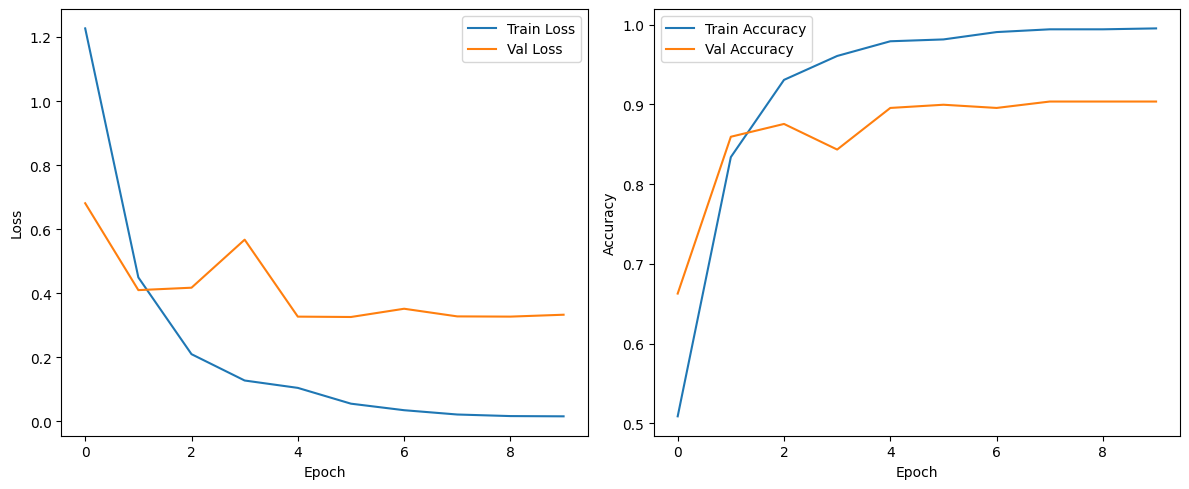

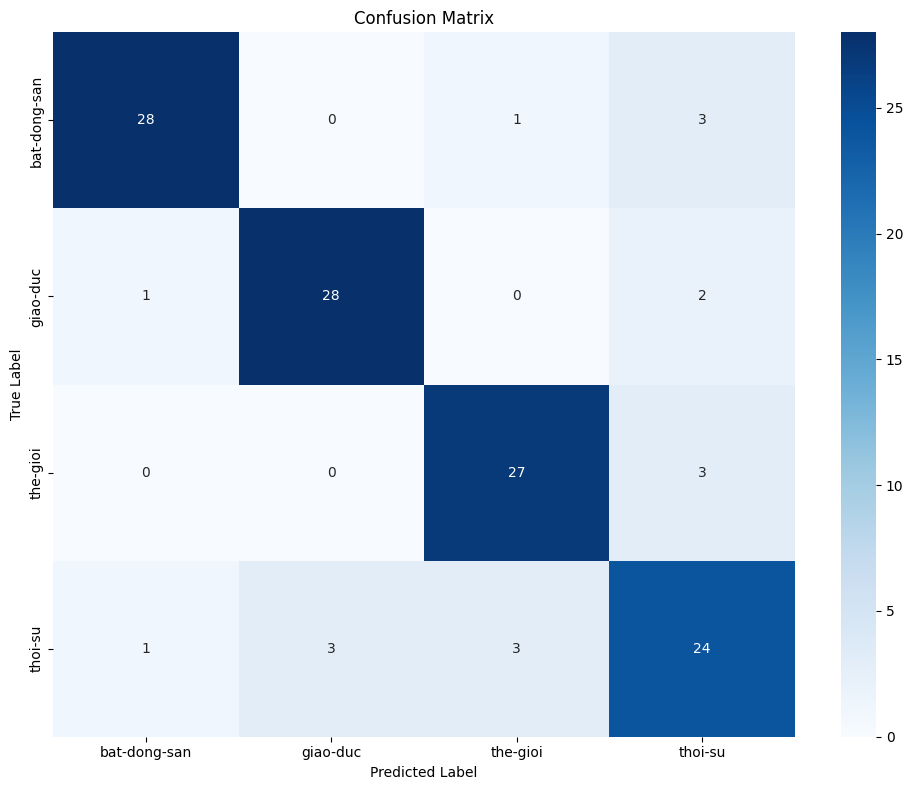

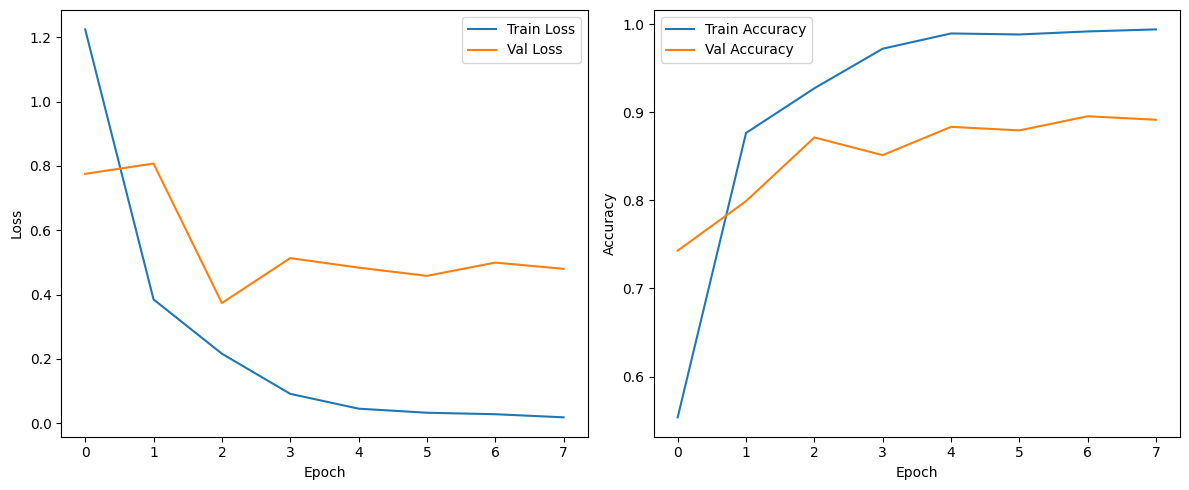

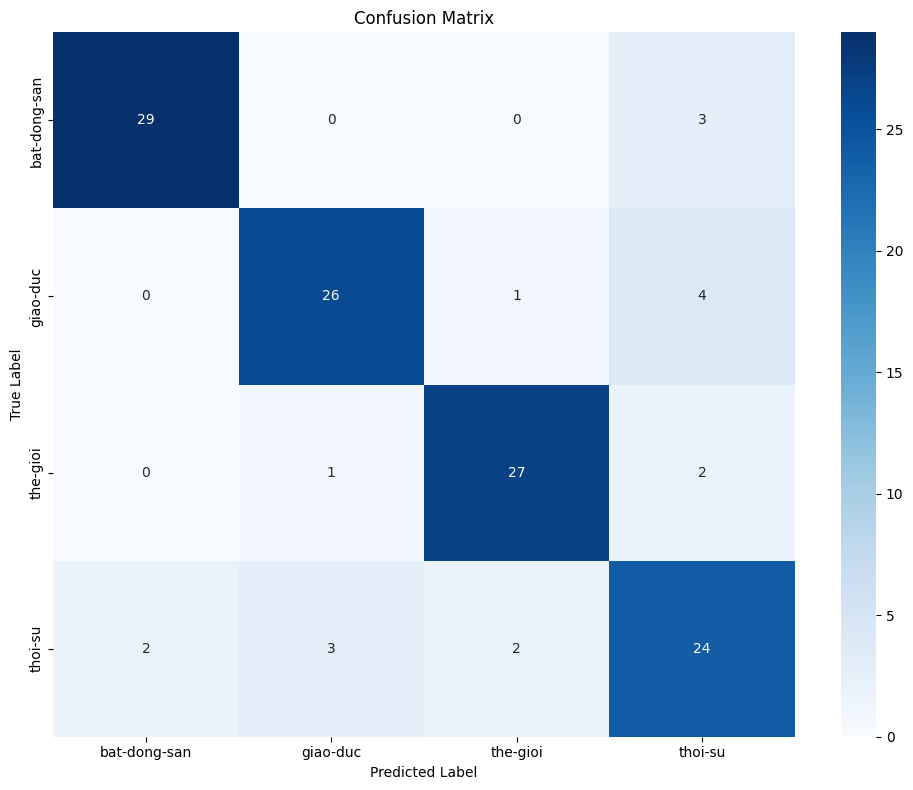

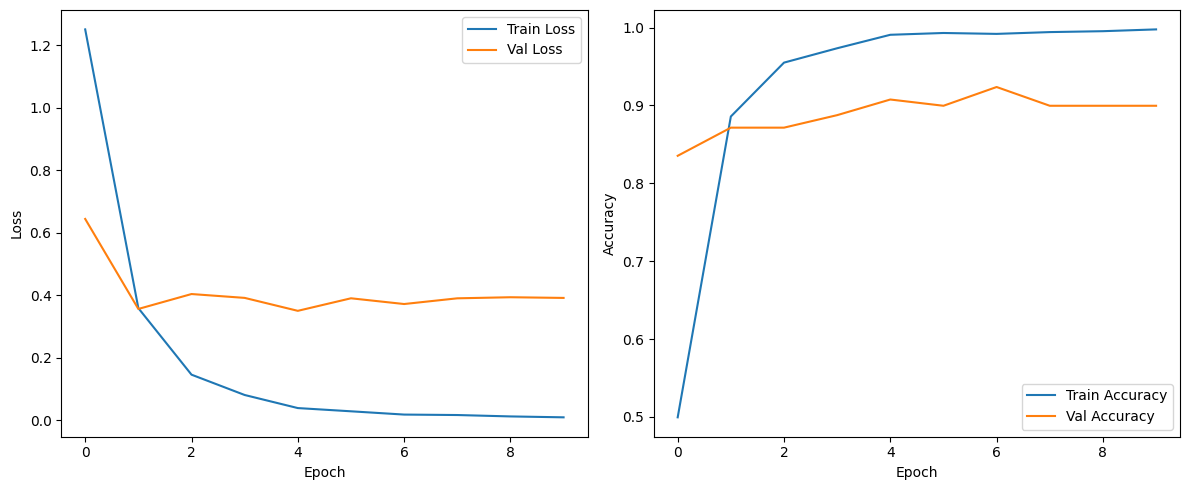

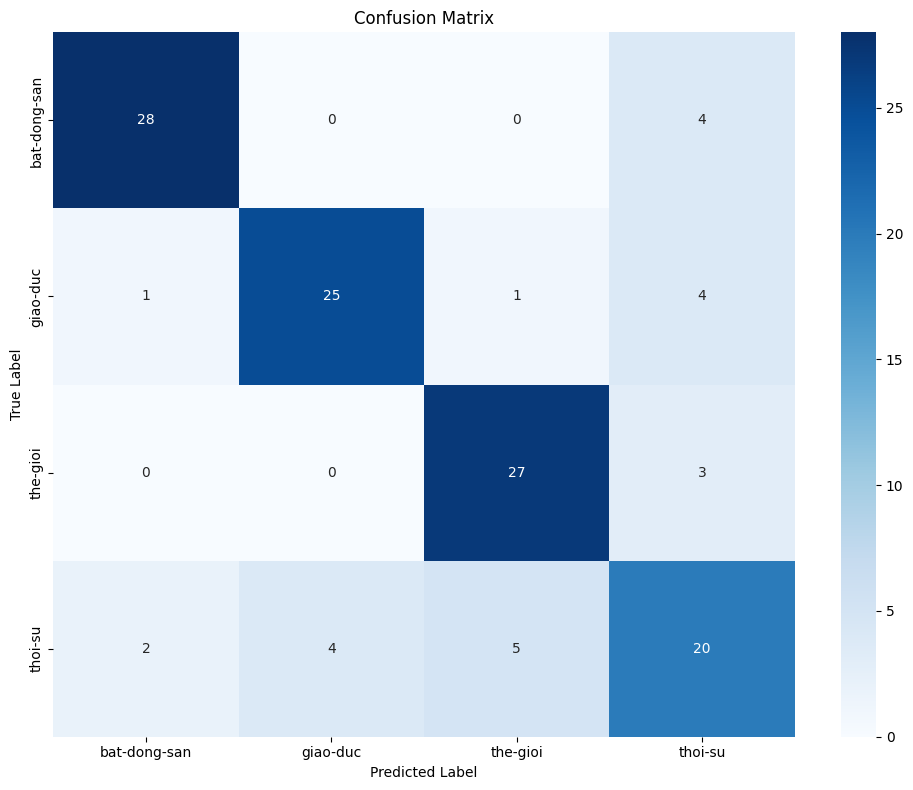

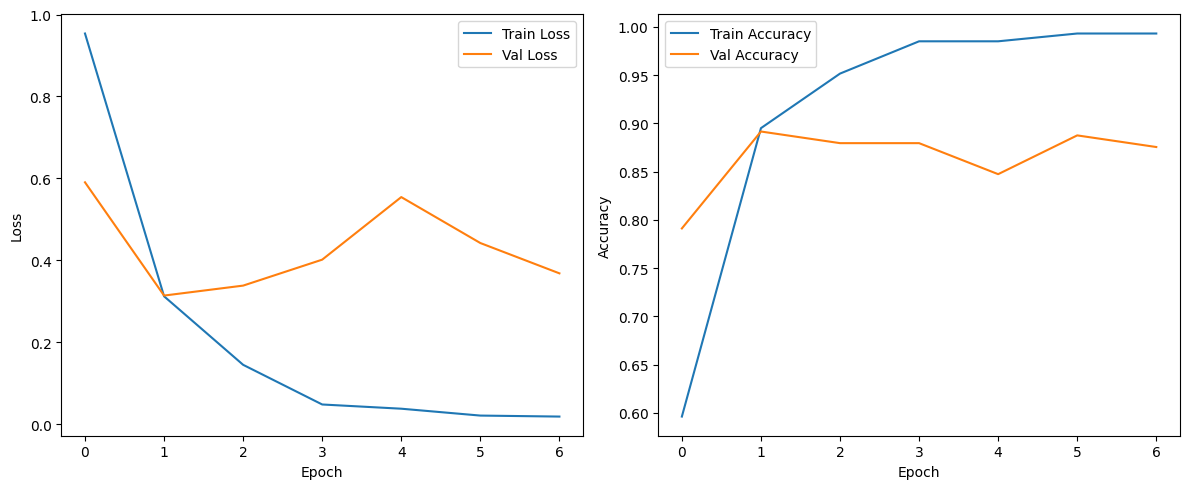

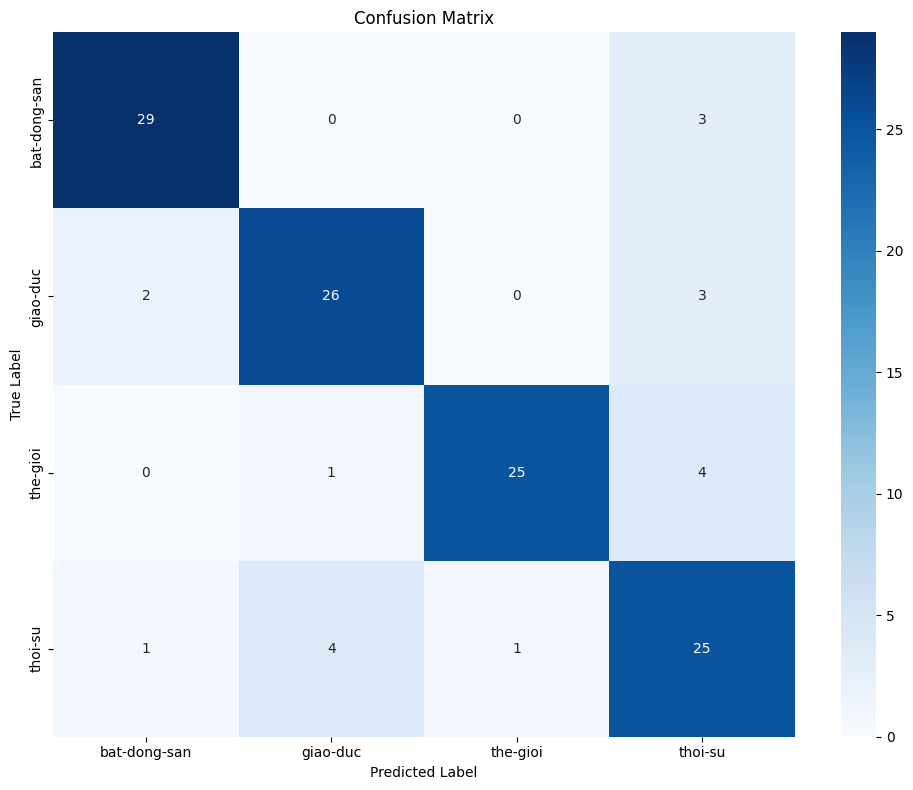

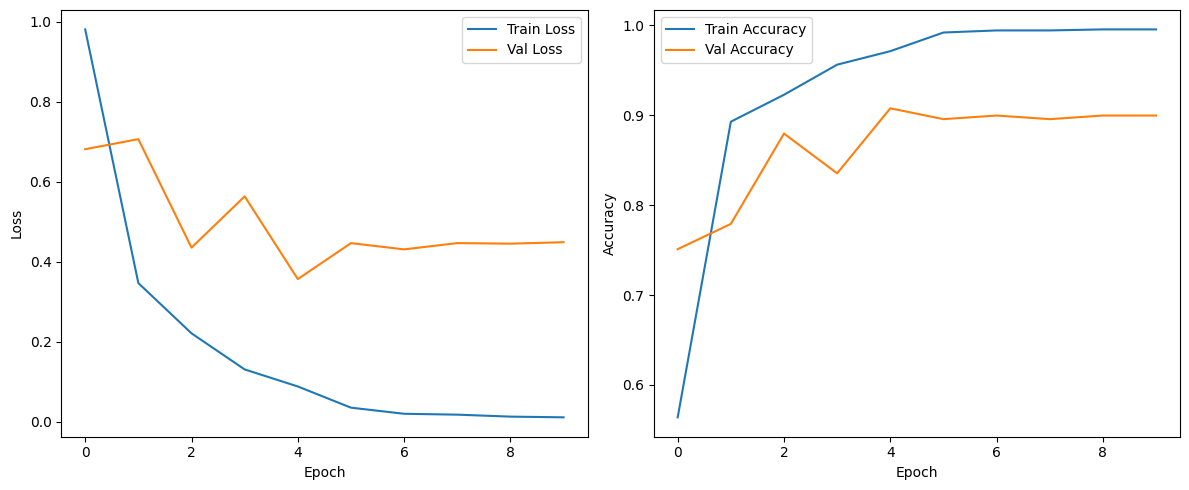

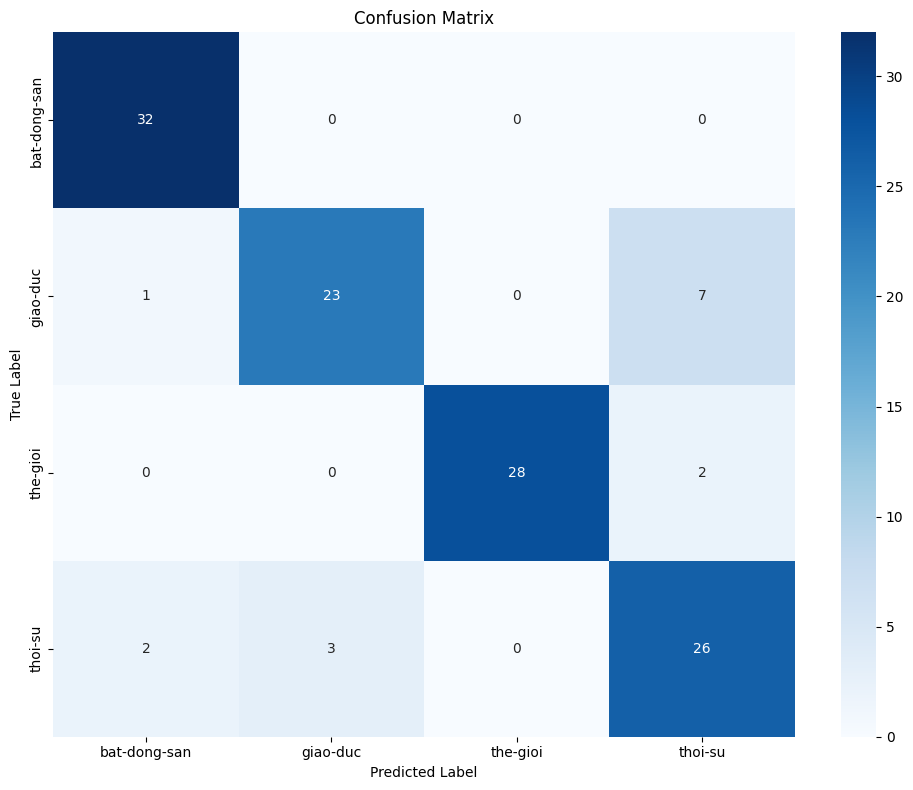

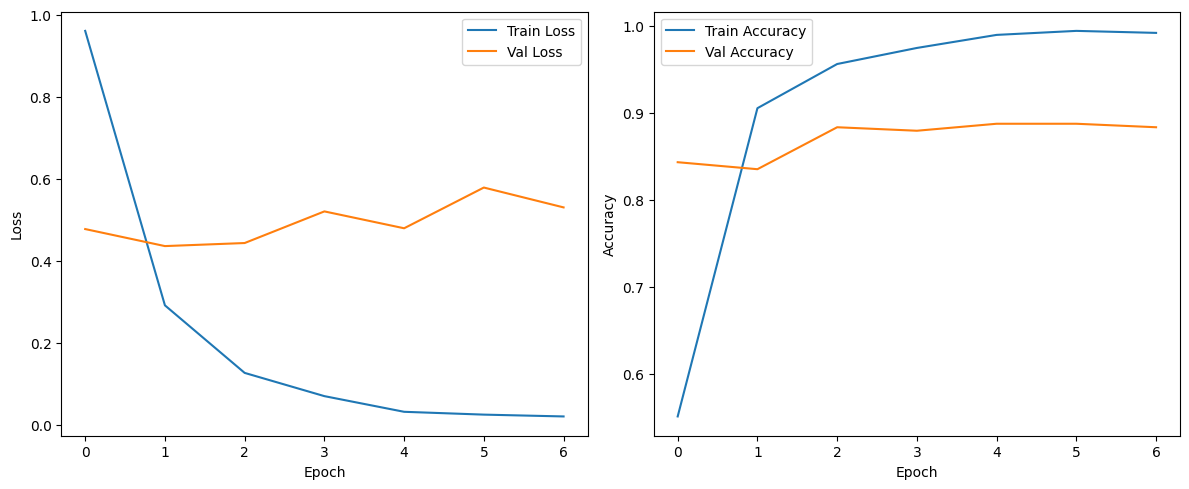

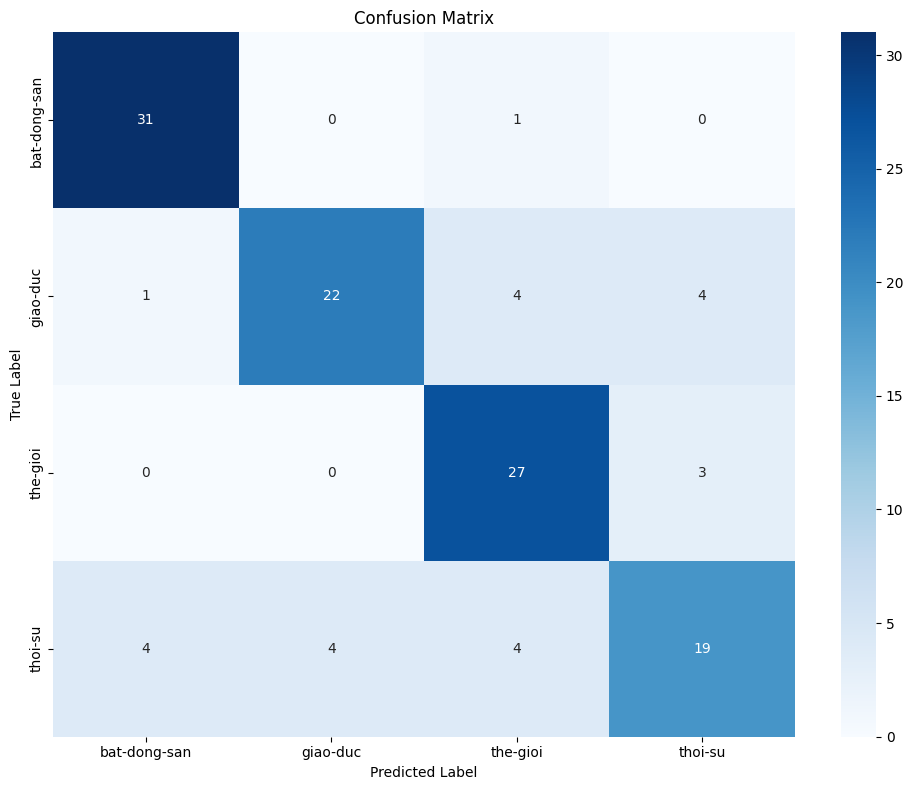

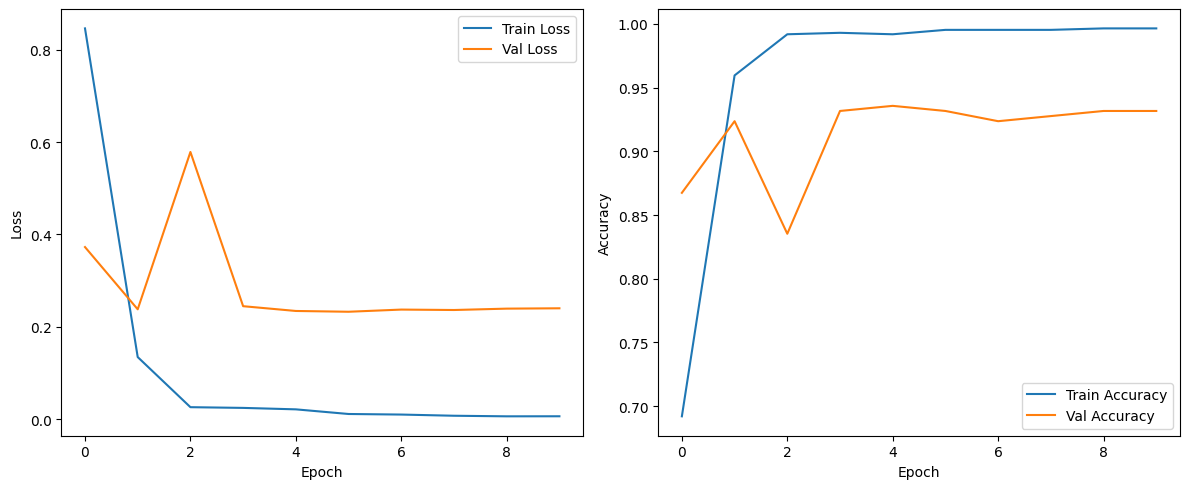

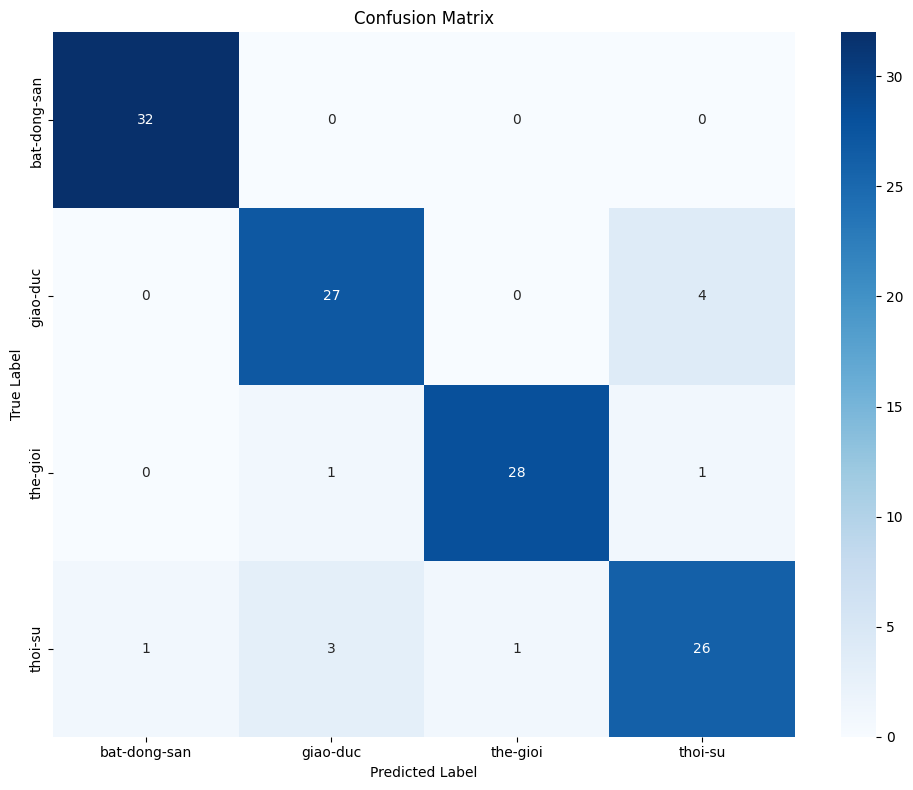

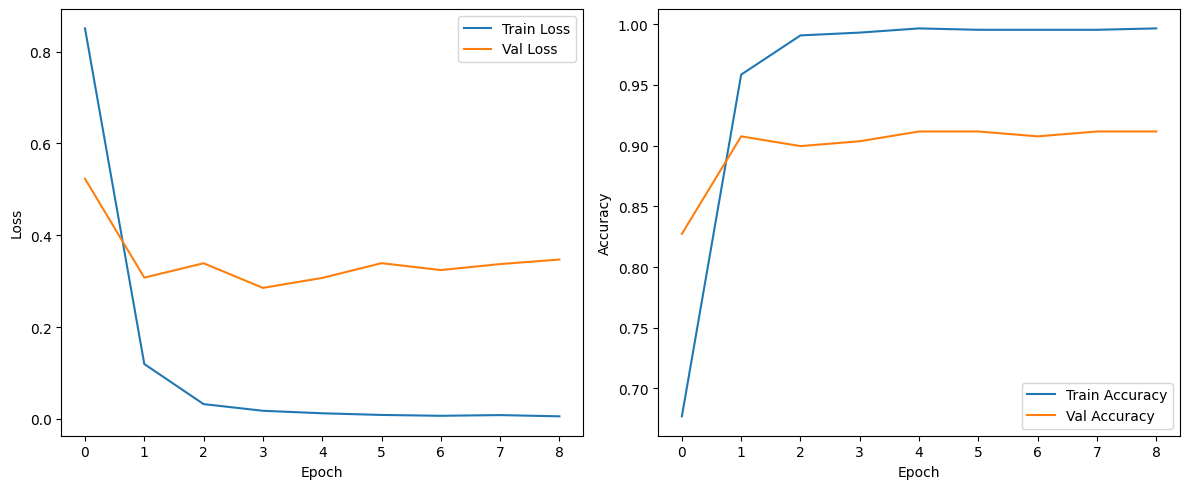

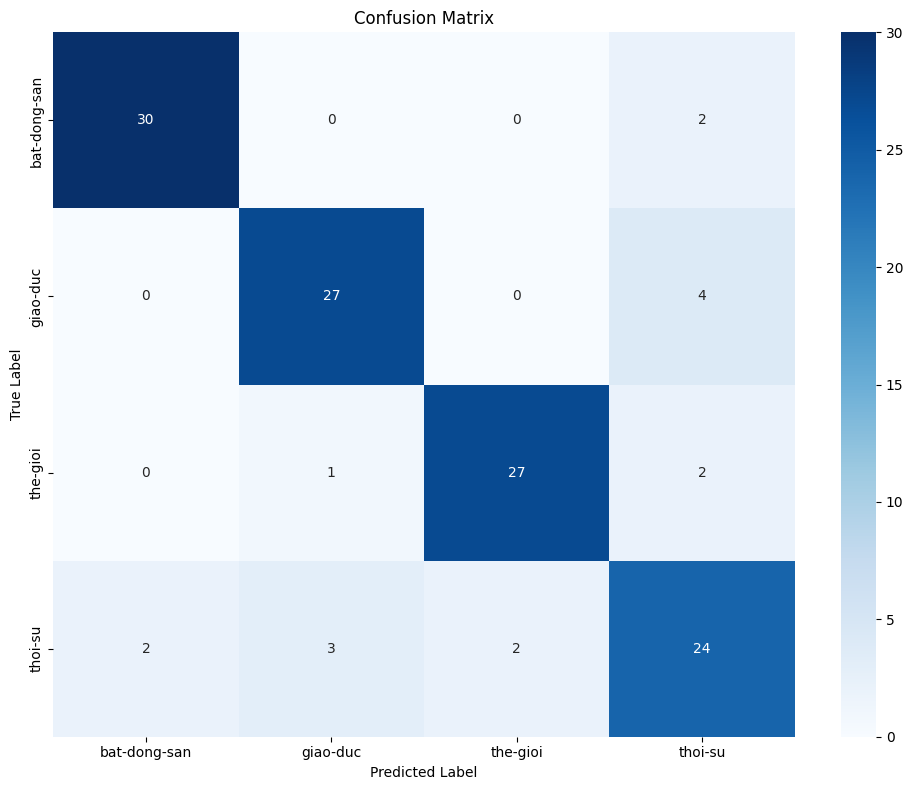

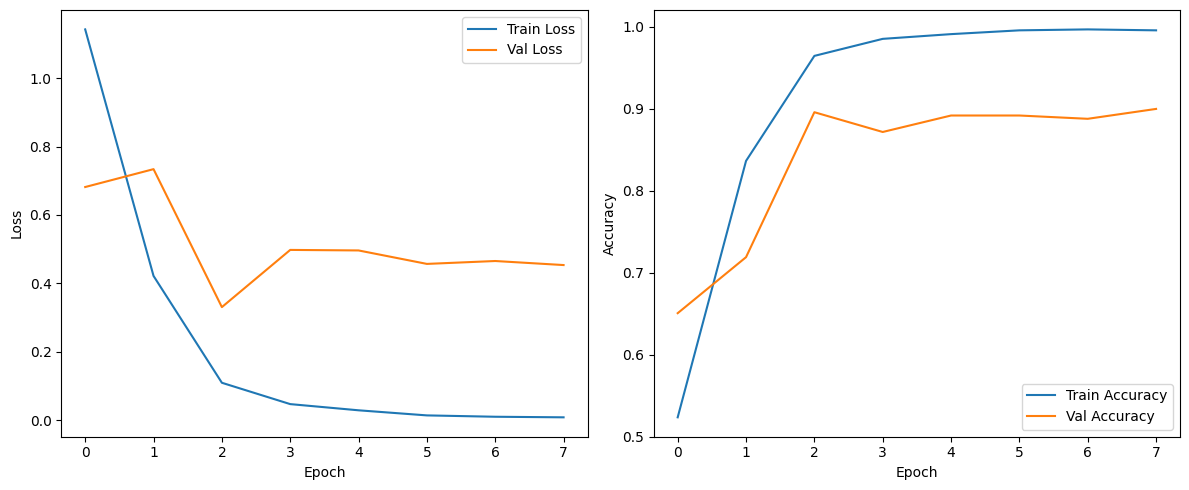

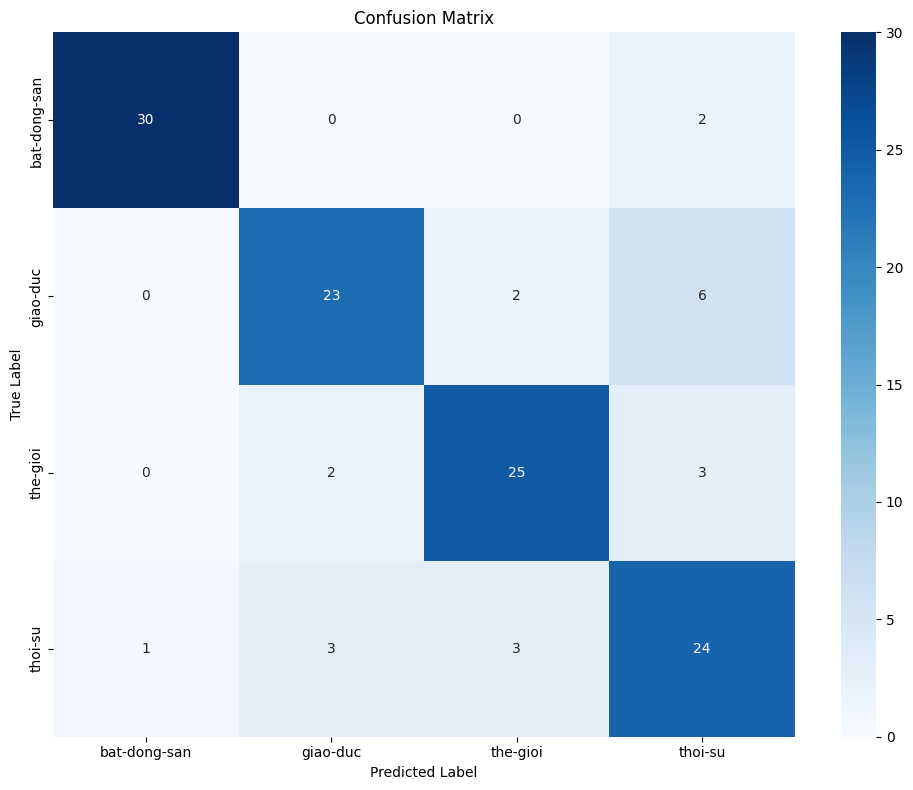

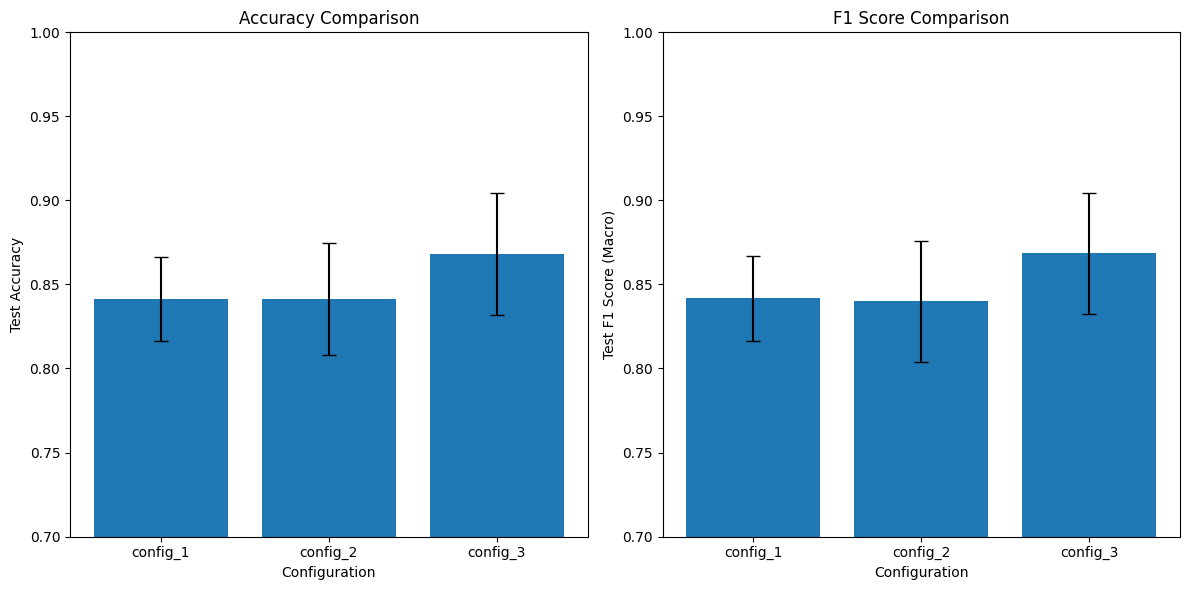

In [ ]:
def main():
    # Bước 1: Đăng nhập wandb (nếu chưa đăng nhập)
    try:
        wandb.login()
        print("Đã đăng nhập vào Wandb")
    except:
        print("Lỗi khi đăng nhập Wandb. Vui lòng đăng nhập thủ công bằng lệnh: wandb login")
        return

    # Bước 2: Kiểm tra dữ liệu
    mapping_file = os.path.join(DATA_DIR, "mapping_data.json")
    if not os.path.exists(mapping_file):
        print("Không tìm thấy dữ liệu. Bắt đầu crawl dữ liệu...")
        crawl_all_categories(pages_per_category=3)

    # Bước 3: Kiểm tra dữ liệu đã tiền xử lý
    processed_data_file = os.path.join(PROCESSED_DATA_DIR, "vocab.pkl")
    if not os.path.exists(processed_data_file):
        print("Chưa có dữ liệu đã tiền xử lý. Bắt đầu tiền xử lý...")
        preprocess_all_data()

    # Bước 4: Chạy thí nghiệm
    print("\nBắt đầu thí nghiệm với các cấu hình khác nhau...")
    summary_df = run_experiments(configs=CONFIGURATIONS, runs_per_config=3)

    print("\nĐã hoàn thành tất cả thí nghiệm!")
    print(f"Kết quả được lưu trong thư mục: 'results' và 'saved_models'")

    return summary_df

# Chạy chương trình
if __name__ == "__main__":
    main()

#10. Dự đoán văn bản mới

In [ ]:
def predict_text(text, model_path=None):
    """Dự đoán thể loại cho một văn bản mới."""
    # Tải vocab và model
    with open(os.path.join(PROCESSED_DATA_DIR, 'vocab.pkl'), 'rb') as f:
        vocab = pickle.load(f)

    # Khởi tạo model
    model = LSTMAttention(
        vocab_size=vocab.vocab_size,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=HIDDEN_DIM,
        attention_dim=ATTENTION_DIM,
        output_dim=len(LABEL_MAP),
        num_layers=NUM_LAYERS,
        bidirectional=BIDIRECTIONAL,
        dropout=DROPOUT,
        pad_idx=vocab.pad_idx
    )

    # Tải model đã huấn luyện
    if model_path is None:
        # Tìm model tốt nhất từ thư mục results
        summary_file = os.path.join("results", "summary_results.json")
        if os.path.exists(summary_file):
            with open(summary_file, 'r') as f:
                summary = json.load(f)

            # Sắp xếp theo độ chính xác giảm dần
            summary.sort(key=lambda x: x["avg_test_accuracy"], reverse=True)
            best_config = summary[0]["config_name"]
            model_path = os.path.join(MODEL_SAVE_DIR, f"{best_config}_run1", "best_model.pt")
        else:
            # Sử dụng model mặc định
            model_path = os.path.join(MODEL_SAVE_DIR, "config_1_run1", "best_model.pt")

    # Kiểm tra model
    if not os.path.exists(model_path):
        print(f"Không tìm thấy model tại {model_path}")
        return None

    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()

    # Tiền xử lý văn bản
    processed_text = preprocess_text(text)

    # Chuyển thành tensor
    text_tensor = vocab.text_to_indices(processed_text, MAX_SEQ_LEN).unsqueeze(0).to(DEVICE)

    # Dự đoán
    with torch.no_grad():
        predictions, attention_weights = model(text_tensor)
        probabilities = torch.softmax(predictions, dim=1).cpu().numpy()[0]
        predicted_class = torch.argmax(predictions, dim=1).item()

    # Lấy kết quả
    predicted_category = INV_LABEL_MAP[predicted_class]
    all_probs = {INV_LABEL_MAP[i]: float(probabilities[i]) for i in range(len(LABEL_MAP))}

    # Trả về kết quả
    return {
        "category": predicted_category,
        "probabilities": all_probs,
        "attention_weights": attention_weights.cpu().numpy()
    }

# Ví dụ sử dụng hàm dự đoán
def test_prediction():
    test_text = """
    5.000 chuyến bay đi và đến TP HCM dịp 30/4
Dịp nghỉ lễ 30/4-1/5 có hơn 5.000 chuyến bay đi và đến sân bay Tân Sơn Nhất, chiếm gần 70% trong tổng số hơn 7.500 chuyến bay nội địa dự kiến khai thác trên cả nước.

Theo Cục Hàng không, trong giai đoạn cao điểm từ 30/4 đến 4/5, các hãng hàng không Việt Nam dự kiến cung ứng khoảng 1,5 triệu ghế trên hơn 7.500 chuyến bay nội địa, trung bình 685 chuyến mỗi ngày, tăng 21% so với cùng kỳ năm 2024. TP HCM là tâm điểm với 5.083 chuyến bay nội địa (hơn một triệu ghế, trung bình 462 chuyến/ngày). Riêng tuyến Hà Nội - TP HCM có hơn 1.200 chuyến bay được lên kế hoạch, tăng 16% so với năm trước.
"""

    result = predict_text(test_text)

    if result:
        print(f"Thể loại dự đoán: {result['category']}")
        print("\nXác suất các thể loại:")
        for category, prob in sorted(result['probabilities'].items(), key=lambda x: x[1], reverse=True):
            print(f"- {category}: {prob:.4f}")

#test_prediction()